In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

from nsgpytorch import nsgp, plot_nsgp_1d, plot_nsgp_2d, nsgp_posterior, NSGP, plot_kernel_1d
import torch

torch.set_default_dtype(torch.float64) # default is float32 but this is to low for SPD
torch.set_grad_enabled(False)

#set device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device chosen: {dev}")

Device chosen: cuda


# 1D example

In [15]:
class TrueModel:
    def __init__(self, x, f):
        self.x = x
        self.f = f

    def to(self, dev):
        self.x = self.x.to(dev)
        self.f = self.f.to(dev)


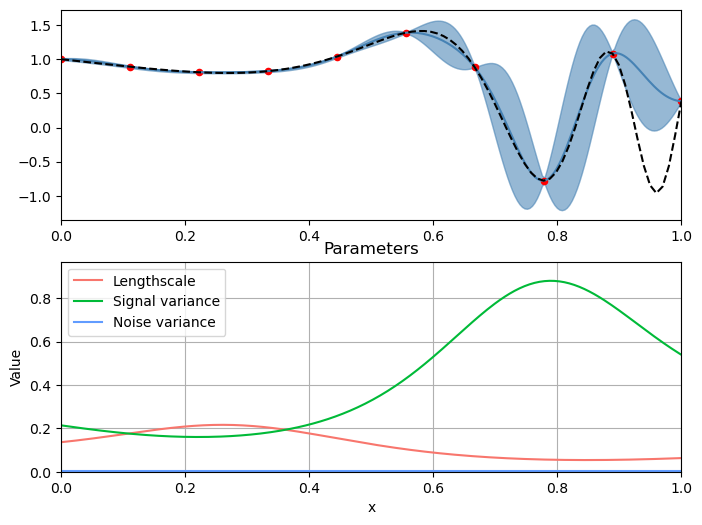

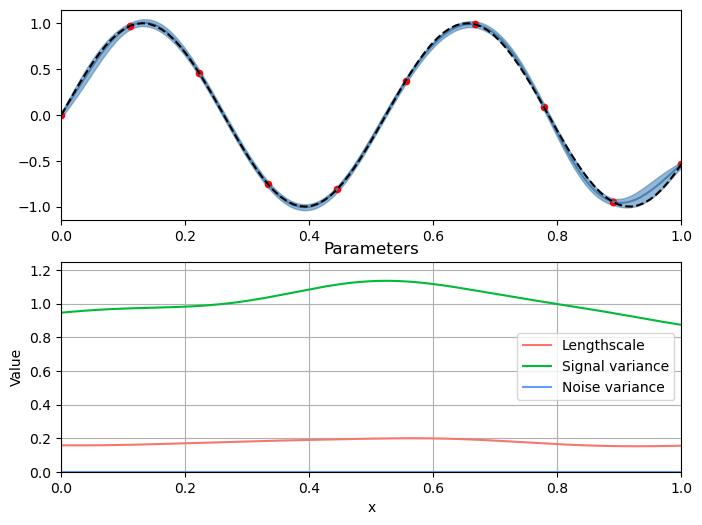

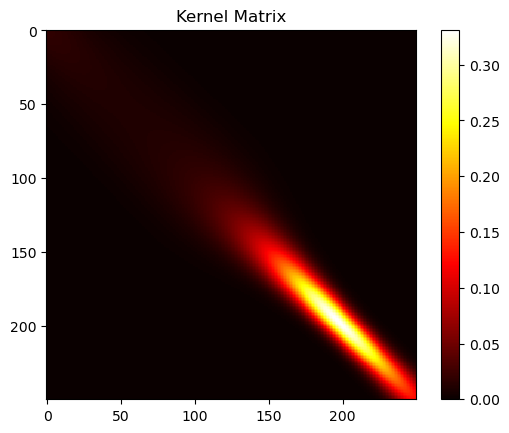

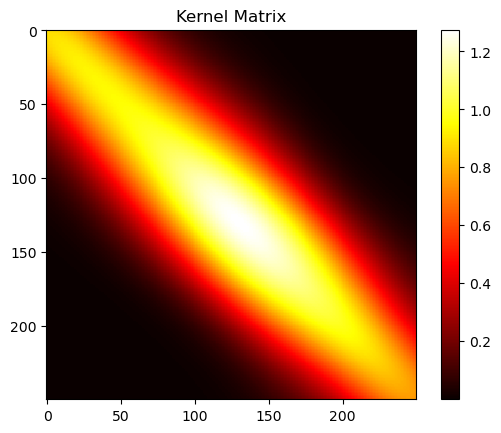

tensor([[1.3314],
        [0.7699]], device='cuda:0')

In [16]:
def f1(x1):
    """Defines a smooth function without noise."""
    return torch.sin((x1 * 6) ** 4 * 0.01) + (1 - x1)

def f2(x1):
    """Defines a second target function."""
    return torch.sin(((x1) * 12)) # Example different function


# Generate training data (input values)
Xt = torch.linspace(0, 1, 10).reshape(-1,1).to(dev)  # 10 evenly spaced points between 0 and 1
y1_pred1D = f1(Xt).reshape(-1,1)  # Compute corresponding function values
y2_pred1D = f2(Xt).reshape(-1,1) 

# Stack outputs to form a multi-output dataset
y_pred_multi = torch.cat([y1_pred1D, y2_pred1D], dim=1).to(dev)  # Shape: (10, 2)

# Initialize the NSGP model
lgp = NSGP()
lgp.to(dev)

# Define hyperparameters for the NSGP model (optional)
hyperparameters = {
    "initial_lengthscale": [0.2, 0.05, 0.1, 0.2, 0.05, 0.1, 0.2, 0.05, 0.1],      # Initial lengthscale for the kernel
    "initial_signal_variance": [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8],   # Initial signal variance
    "initial_noise_variance": [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],   # Initial noise variance
    "beta_lengthscale": 0.2,       # Controls variation of lengthscale
    "beta_signal_variance": 0.2,   # Controls variation of signal variance
    "beta_noise_variance": 0.3,    # Controls variation of noise variance
    "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
    "alpha_signal_variance": 1,    # Alpha parameter for signal variance
    "alpha_noise_variance": 1,     # Alpha parameter for noise variance
    "verbose_output": False,
}

lgp.set_params(**hyperparameters)

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", n_restarts=9, max_iteration=5000)

# Train the NSGP model with training data
# The last argument "ls" specifies which nonstationary functions to learn (lengthscale, signal variance)
lgp.fit(Xt, y_pred_multi, "ls", batch_size=9)

# Generate test data for true function visualization (optional)
Xt_true = torch.linspace(0, 1, 100).reshape(-1,1).to(dev)  # 100 test points for smooth function visualization
y1_true1D = f1(Xt_true).reshape(-1,1)  # Compute true function values
y2_true1D = f2(Xt_true).reshape(-1,1)  # Compute true function values
y_true_multi = torch.cat([y1_true1D, y2_true1D], dim=1).to(dev)  # (n_samples, n_targets)
truemodel = TrueModel(Xt_true, y_true_multi)  # Store true model data for comparison

# Plot the NSGP model results
# - `plotlatent=True` to visualize learned latent parameters (like lengthscale)
# - `plotderivs=False` to disable derivative visualization
# - `truemodel=truemodel` to compare with the true function
plot_nsgp_1d(lgp.gp, plotlatent=True, plotderivs=False, truemodel=truemodel)

plot_kernel_1d(lgp.gp)

# Test the trained model with a new input (0.6)
Xt_test = torch.tensor([0.6]).reshape(-1,1).to(dev)
lgp.predict(Xt_test, return_std=False, return_cov=False)  # Get the predicted function value at x = 0.6

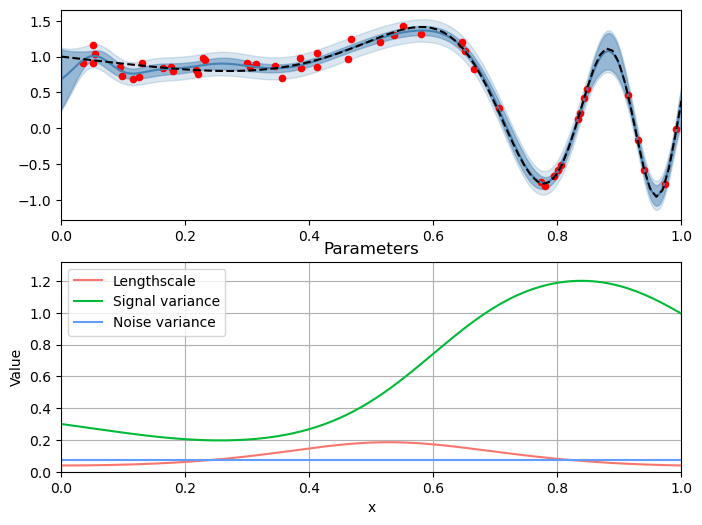

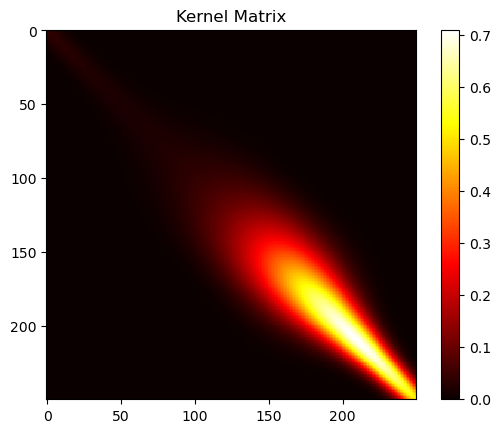

In [17]:
def f_noisy(x1):
    return torch.sin((x1 * 6) ** 4 * 0.01) + (1 - x1) + (torch.rand(x1.shape, device=x1.device) - 0.5) * 0.5 * (1 - x1)

def f(x1):
    return torch.sin((x1 * 6) ** 4 * 0.01) + (1 - x1)

# Create noisy model
Xt = torch.rand((50, 1)).reshape(-1,1).to(dev)
y1_pred1D = f_noisy(Xt).reshape(-1,1)
y_pred_multi = torch.cat([y1_pred1D], dim=1)  # Shape: (50, 1)

# Initialize the NSGP model
lgp = NSGP()
lgp.to(dev)

# Define hyperparameters for the NSGP model (optional)
hyperparameters = {
    "initial_lengthscale": [0.2, 0.05, 0.1, 0.2, 0.05, 0.1, 0.2, 0.05, 0.1],      # Initial lengthscale for the kernel
    "initial_signal_variance": [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8],   # Initial signal variance
    "initial_noise_variance": [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],   # Initial noise variance
    "beta_lengthscale": 0.2,       # Controls variation of lengthscale
    "beta_signal_variance": 0.2,   # Controls variation of signal variance
    "beta_noise_variance": 0.3,    # Controls variation of noise variance
    "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
    "alpha_signal_variance": 1,    # Alpha parameter for signal variance
    "alpha_noise_variance": 1,     # Alpha parameter for noise variance
    "verbose_output": False,
}

lgp.set_params(**hyperparameters)

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", n_restarts=9, max_iteration=5000)

# Train the NSGP model with training data
lgp.fit(Xt, y_pred_multi, "lso", batch_size=9)

# Generate test data for true function visualization (optional)
Xt_true = torch.linspace(0, 1, 100).reshape(-1,1).to(dev)  # 100 test points for smooth function visualization
y_true1D = f(Xt_true).reshape(-1,1)  # Compute true function values
y_true_multi = torch.cat([y_true1D], dim=1)  # Shape: (50, 1)
truemodel = TrueModel(Xt_true, y_true_multi)  # Store true model data for comparison

# Plot the NSGP model results
plot_nsgp_1d(lgp.gp, plotlatent=True, plotderivs=False, truemodel=truemodel)

plot_kernel_1d(lgp.gp)

# 2D example

Optimizing 4 targets with 9 restarts using 8 parallel processes...
Starting Process 0 in slot 0
Starting Process 1 in slot 1
Starting Process 2 in slot 2
Starting Process 3 in slot 3
Starting Process 4 in slot 4
Starting Process 5 in slot 5
Starting Process 6 in slot 6
Starting Process 7 in slot 7
Process 6 converged after 97 iterations with MLL of 864.8191930412522, freeing slot 6
Starting Process 8 in slot 6
Process 7 converged after 109 iterations with MLL of 957.2627813459651, freeing slot 7
Starting Process 9 in slot 7
Process 0 converged after 115 iterations with MLL of 851.4406823505742, freeing slot 0
Starting Process 10 in slot 0
Process 2 converged after 116 iterations with MLL of 726.6277251434495, freeing slot 2
Starting Process 11 in slot 2
Process 1 converged after 118 iterations with MLL of 864.2569708682174, freeing slot 1
Starting Process 12 in slot 1
Process 3 converged after 122 iterations with MLL of 943.9085628165458, freeing slot 3
Starting Process 13 in slot 3
Pr

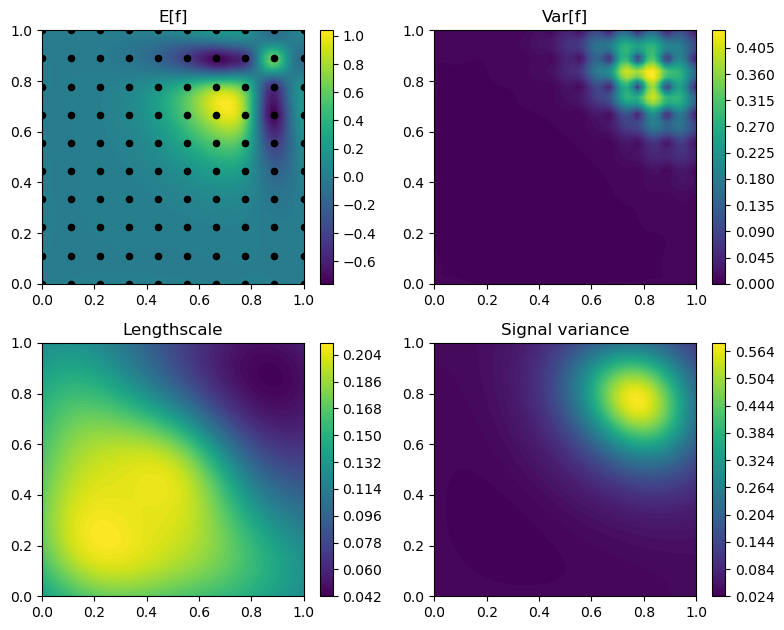

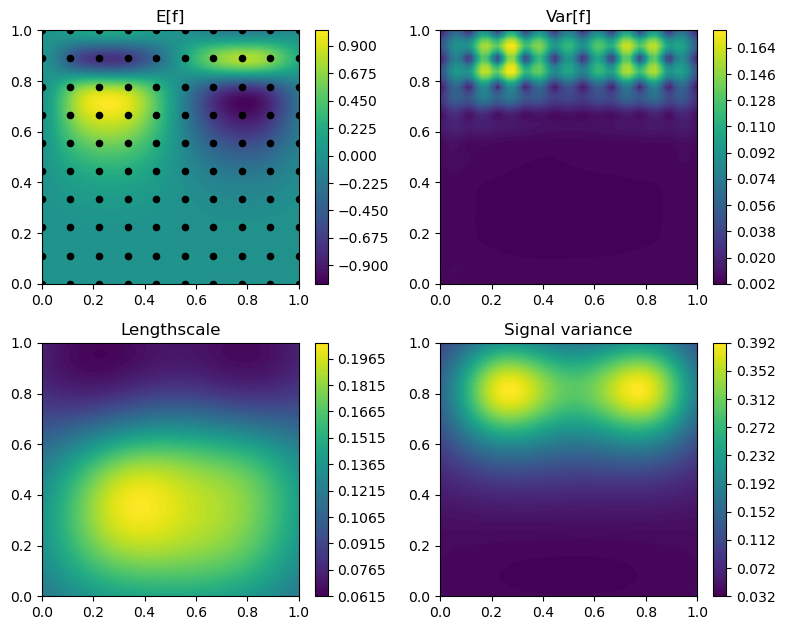

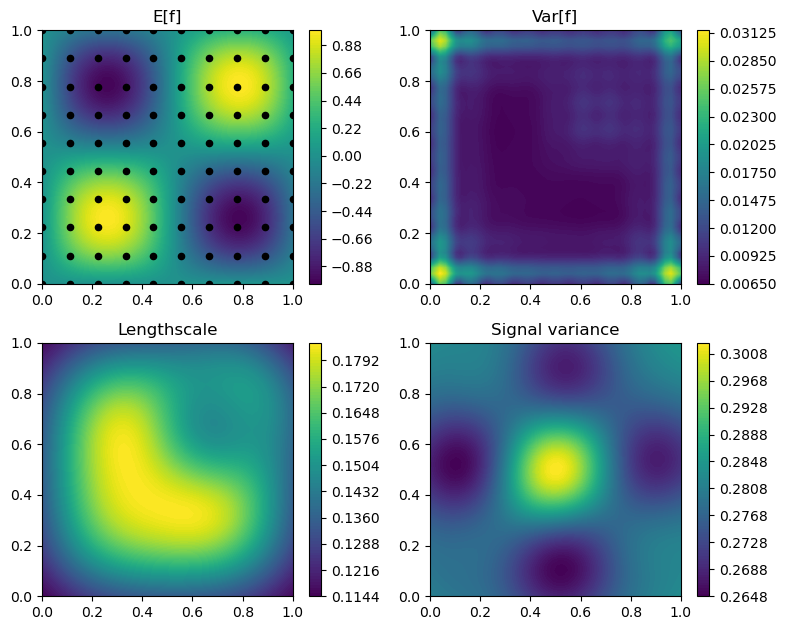

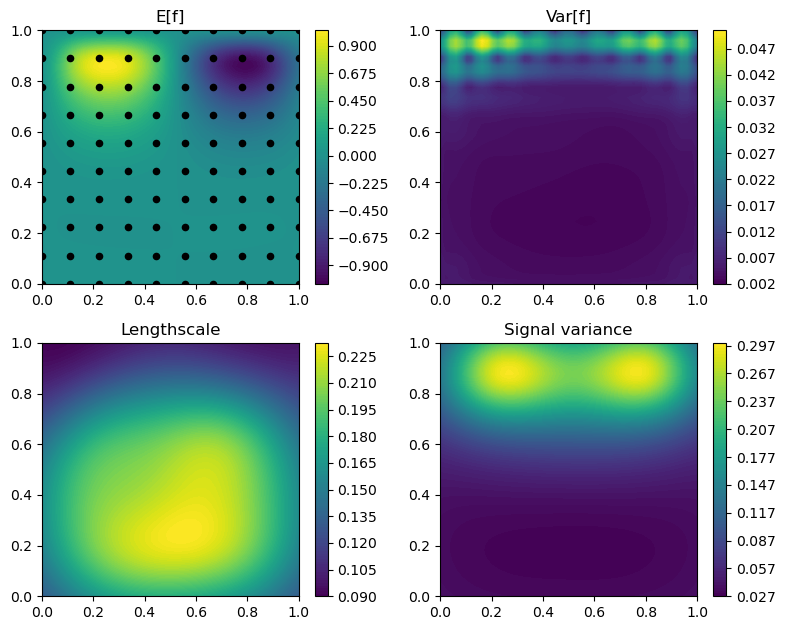

In [18]:
# Define function
def f1(x1, x2):
    return torch.sin((x1 * 6) ** 4 * 0.005) * torch.sin((x2 * 6) ** 4 * 0.005)

# Define function
def f2(x1, x2):
    return torch.sin(x1 * 6) * torch.sin((x2 * 6) ** 4 * 0.005)

# Define function
def f3(x1, x2):
    return torch.sin(x1 * 6) * torch.sin(x2 * 6)

# Define function
def f4(x1, x2):
    return torch.sin(x1 * 6) * torch.sin((1 - x2 * 6) ** 4 * 0.005)

# Create grid
x1 = torch.linspace(0, 1, 10).to(dev)
x2 = torch.linspace(0, 1, 10).to(dev)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
Xt = torch.column_stack((X1.ravel(), X2.ravel())).to(dev)

# Compute function values
y1_pred2D = f1(X1, X2).reshape(-1,1)
y2_pred2D = f2(X1, X2).reshape(-1,1)
y3_pred2D = f3(X1, X2).reshape(-1,1)
y4_pred2D = f4(X1, X2).reshape(-1,1)

# Reshape to column vector
y_pred_multi = torch.cat([y1_pred2D, y2_pred2D, y3_pred2D, y4_pred2D], dim=1).to(dev)  # Shape: (100, 1)

# Initialize the NSGP model
lgp = NSGP()
lgp.to(dev)

# Define hyperparameters for the NSGP model (optional)
hyperparameters = {
    "initial_lengthscale": [0.01, 0.05, 0.1, 0.01, 0.05, 0.1, 0.01, 0.05, 0.1],      # Initial lengthscale for the kernel
    "initial_signal_variance": [0.05, 0.05, 0.05, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],   # Initial signal variance
    "initial_noise_variance": [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],   # Initial noise variance
    "beta_lengthscale": 0.2,       # Controls variation of lengthscale
    "beta_signal_variance": 0.2,   # Controls variation of signal variance
    "beta_noise_variance": 0.3,    # Controls variation of noise variance
    "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
    "alpha_signal_variance": 1,    # Alpha parameter for signal variance
    "alpha_noise_variance": 1,     # Alpha parameter for noise variance
    "verbose_output": True,
}

lgp.set_params(**hyperparameters)

# Set the optimization parameters (optional)
lgp.optimizer(optimizer="grad", n_restarts=9, max_iteration=5000)

# Train the NSGP model with training data
lgp.fit(Xt, y_pred_multi, "ls", batch_size=8)

# Plot results
plot_nsgp_2d(lgp.gp)

# 2D adaptive sampling 

Iteration 1


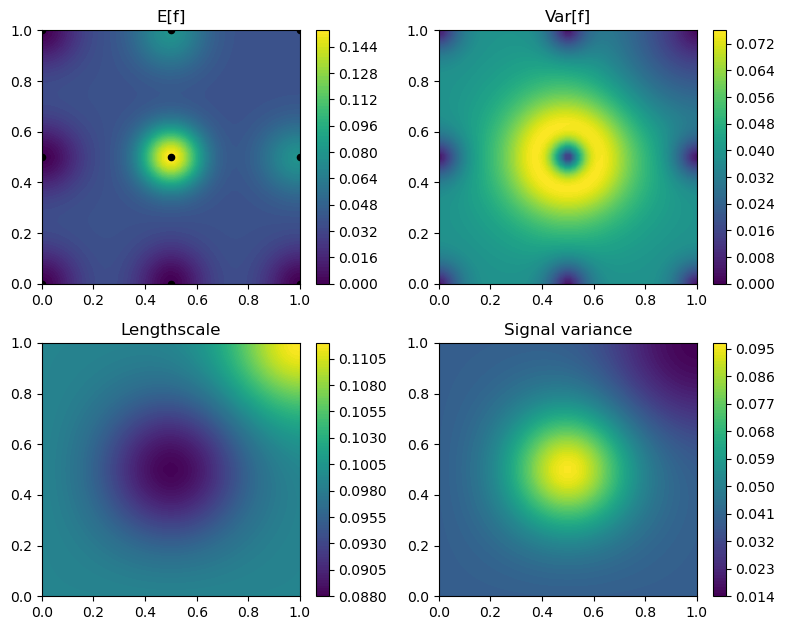

Iteration 2


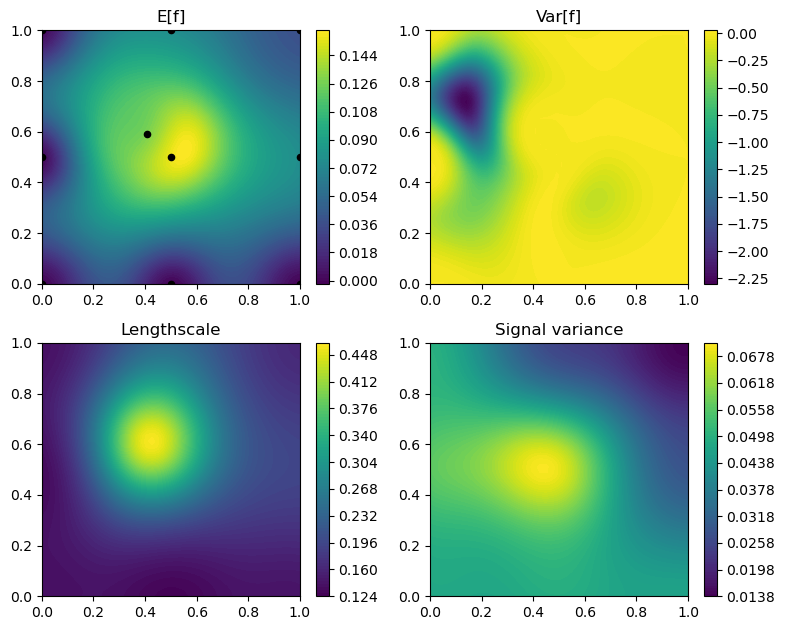

Iteration 3


KeyboardInterrupt: 

In [19]:
# adaptive sampling test:

# Define function
def f(x1, x2):
    return torch.sin((x1 * 6) ** 4 * 0.005) * torch.sin((x2 * 6) ** 4 * 0.005)

# Create grid
x1_train = torch.linspace(0, 1, 3).to(dev)
x2_train = torch.linspace(0, 1, 3).to(dev)
X1_train, X2_train = torch.meshgrid(x1_train, x2_train, indexing="ij")
Xt_train = torch.column_stack((X1_train.ravel(), X2_train.ravel()))

# Compute function values
y_train = f(X1_train, X2_train)

# Reshape to column vector
y_train = y_train.reshape(-1,1).to(dev)

# Define hyperparameters for the NSGP model (optional)
hyperparameters = {
    "initial_lengthscale": [0.01, 0.05, 0.1, 0.01, 0.05, 0.1, 0.01, 0.05, 0.1],      # Initial lengthscale for the kernel
    "initial_signal_variance": [0.05, 0.05, 0.05, 0.3, 0.3, 0.3, 0.5, 0.5, 0.5],   # Initial signal variance
    "initial_noise_variance": [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],   # Initial noise variance
    "beta_lengthscale": 0.2,       # Controls variation of lengthscale
    "beta_signal_variance": 0.2,   # Controls variation of signal variance
    "beta_noise_variance": 0.3,    # Controls variation of noise variance
    "alpha_lengthscale": 1,        # Alpha parameter for lengthscale
    "alpha_signal_variance": 1,    # Alpha parameter for signal variance
    "alpha_noise_variance": 1,     # Alpha parameter for noise variance
    "verbose_output": False,
}

for i in range(100):
    print(f"Iteration {i+1}")

    # Initialize the NSGP model
    lgp = NSGP()
    lgp.to(dev)

    # Set hyperparameters
    lgp.set_params(**hyperparameters)

    # Set the optimization parameters (optional)
    lgp.optimizer(optimizer="grad", n_restarts=9, max_iteration=5000)

    # Train the NSGP model with training data
    lgp.fit(Xt_train, y_train, "ls", batch_size=9)

    # Create evaluation grid
    x1_evaluate = torch.linspace(0, 1, 50).to(dev)
    x2_evaluate = torch.linspace(0, 1, 50).to(dev)
    X1_evaluate, X2_evaluate = torch.meshgrid(x1_evaluate, x2_evaluate, indexing="ij")
    Xt_evaluate = torch.column_stack((X1_evaluate.ravel(), X2_evaluate.ravel()))

    # Compute posterior values
    _, ftstd = lgp.predict(Xt_evaluate, return_std=True, return_cov=False) 

    # Find the location of highest uncertainty
    max_index = torch.argmax(ftstd)  # Index of max std
    new_sample = Xt_evaluate[max_index]  # Corresponding (x1, x2) point

    # Evaluate function at new sample
    new_y = f(*new_sample).reshape(1, 1)  # Ensure it's a column vector

    # Add new sample to training set
    Xt_train = torch.vstack((Xt_train, new_sample))
    y_train = torch.vstack((y_train, new_y))

    # Plot results
    plot_nsgp_2d(lgp.gp)

In [ ]:
print(lgp.device)

cuda
